# Exercise 6: Simple Features

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares
import scipy.ndimage
from skimage import color

## Programming exercise: Harris corner detector

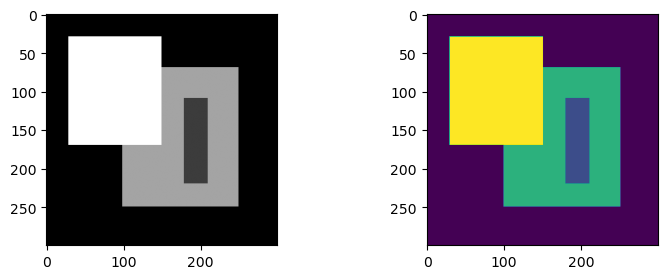

(300, 300, 3)
(300, 300)


In [55]:
im = cv2.imread('data/TestIm1.png')[:,:,::-1]
im = im.astype(float)/255
im_gray = color.rgb2gray(im)

fig, ax = plt.subplots(1,2, figsize=(9,3))
ax[0].imshow(im)
ax[1].imshow(im_gray)
plt.show()

print(im.shape)
print(im_gray.shape)

In [91]:
sigma = 5
epsilon = 5
k = 0.06

### Exercise 6.1

In [117]:
def gaussian1DKernel(sigma):
    '''
    Computes kernels of Gaussian and its derivatives.
    Parameters
    ----------
    t : float
        Vairance - t.

    Returns
    -------
    g : numpy array
        Gaussian.
    dg : numpy array
        First order derivative of Gaussian.
    ddg : numpy array
        Second order derivative of Gaussian
    dddg : numpy array
        Third order derivative of Gaussian.

    '''

    kSize = 5
    x = np.arange(int(-np.ceil(sigma*kSize)), int(np.ceil(sigma*kSize))+1)
    x = np.reshape(x,(-1,1))
    g = np.exp(-x**2/(2*sigma**2))
    g = g/np.sum(g)
    dg = -x/sigma**2*g
    return g, dg

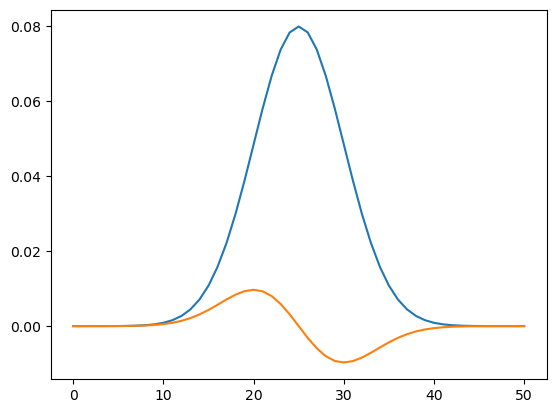

In [118]:
# check plot
g, dg = gaussian1DKernel(sigma)
plt.plot(g)
plt.plot(dg)
plt.show()

In [119]:
# verif normalization
sum(g)

array([1.])

### Exercise 6.2

In [120]:
def gaussianSmoothing(im, sigma):
    if sigma == 0:
        return im, im, im
    else:
        g, dg = gaussian1DKernel(sigma)
        I = scipy.ndimage.convolve(scipy.ndimage.convolve(im,g),g.T)
        Ix = scipy.ndimage.convolve(scipy.ndimage.convolve(im,dg.T),g)
        Iy = scipy.ndimage.convolve(scipy.ndimage.convolve(im,dg),g.T)
        return I, Ix, Iy

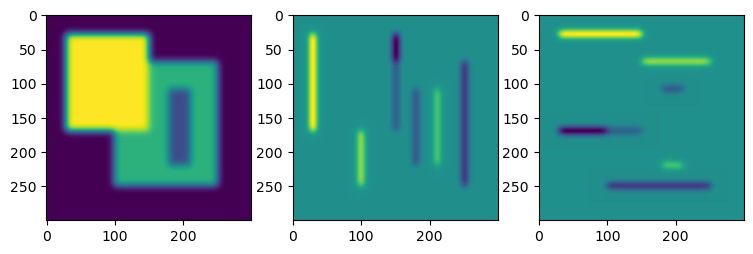

In [121]:
I, Ix, Iy = gaussianSmoothing(im_gray, sigma)

fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].imshow(I)
ax[1].imshow(Ix)
ax[2].imshow(Iy)
plt.show()

### Exercise 6.3

In [135]:
def smoothedHessian(im, sigma, epsilon):
    I, Ix, Iy = gaussianSmoothing(im, sigma)
    g, dg = gaussian1DKernel(epsilon)
    a = scipy.ndimage.convolve(scipy.ndimage.convolve(Ix**2,g),g.T)
    b = scipy.ndimage.convolve(scipy.ndimage.convolve(Iy**2,g),g.T)
    c = scipy.ndimage.convolve(scipy.ndimage.convolve(Ix*Iy,g),g.T)
    C = np.vstack((np.hstack((a,c)), np.hstack((c,b))))
    return C

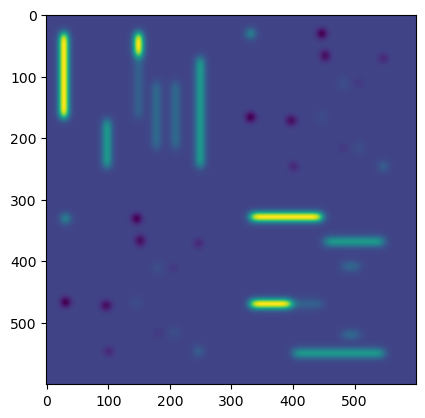

In [136]:
C = smoothedHessian(im_gray, sigma, epsilon)
plt.imshow(C)
plt.show()

### Exercise 6.4

In [137]:
def harrisMeasure(im, sigma, epsilon, k):
    if epsilon == 0:
        return print('error= epsilon = 0')
    I, Ix, Iy = gaussianSmoothing(im, sigma)
    g, dg = gaussian1DKernel(epsilon)
    a = scipy.ndimage.convolve(scipy.ndimage.convolve(Ix**2,g),g.T)
    b = scipy.ndimage.convolve(scipy.ndimage.convolve(Iy**2,g),g.T)
    c = scipy.ndimage.convolve(scipy.ndimage.convolve(Ix*Iy,g),g.T)
    r = a*b - c**2 - k*(a+b)**2
    return r

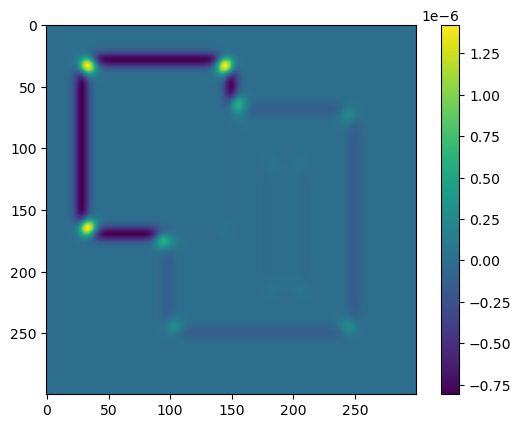

In [162]:
r = harrisMeasure(im_gray, sigma, epsilon, k)

plt.imshow(r)
plt.colorbar()
plt.show()

### Exercise 6.5

In [220]:
def cornerDetector(im, sigma, epsilon, k, tau):
    # thresholding
    r = harrisMeasure(im_gray, sigma, epsilon, k)
    r[r<tau] = 0
    
    #
    maxima = np.zeros(r.shape)
    down = r[:-1,:] - r[1:,:]
    down = np.vstack((down,np.zeros((1,r.shape[1]))))
    maxima[down > 0] += 1
    up = r[1:,:] - r[:-1,:]
    up = np.vstack((np.zeros((1,r.shape[1])),up))
    maxima[up > 0] += 1
    right = r[:,:-1] - r[:,1:]
    right = np.hstack((right, np.zeros((r.shape[0],1))))
    maxima[right > 0] += 1
    left = r[:,1:] - r[:,:-1]
    left = np.hstack((np.zeros((r.shape[0],1)),left))
    maxima[left > 0] += 1
    
    c = np.where(maxima>3)
    
    return c

1.4230576238563797e-07


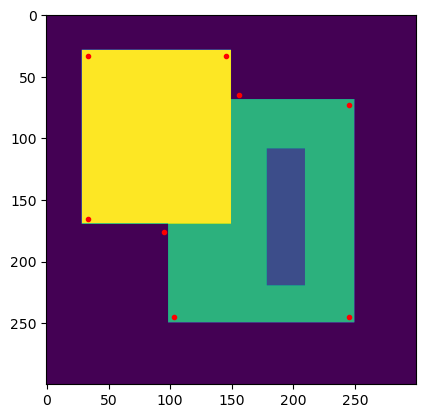

In [228]:
tau = 0.1*r.max()
print(tau)
c = cornerDetector(im_gray, sigma, epsilon, k, tau)

plt.imshow(im_gray)
plt.plot(c[1], c[0], 'r.')
plt.show()

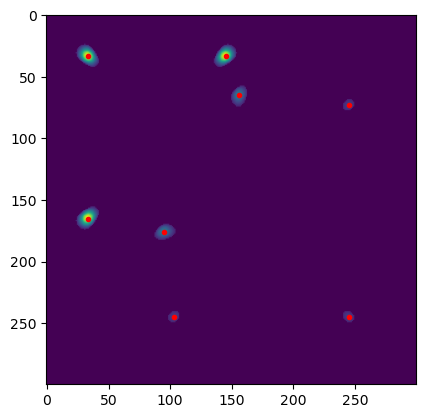

In [229]:
plt.imshow(r)
plt.plot(c[1], c[0], 'r.')
plt.show()

## Programming exercises: Canny edge detection

### Exercise 6.6

In [248]:
im1 = cv2.imread('data/TestIm1.png')[:,:,::-1]
im2 = cv2.imread('data/TestIm2.png')[:,:,::-1]

In [238]:
help(cv2.Canny)

Help on built-in function Canny:

Canny(...)
    Canny(image, threshold1, threshold2[, edges[, apertureSize[, L2gradient]]]) -> edges
    .   @brief Finds edges in an image using the Canny algorithm @cite Canny86 .
    .   
    .   The function finds edges in the input image and marks them in the output map edges using the
    .   Canny algorithm. The smallest value between threshold1 and threshold2 is used for edge linking. The
    .   largest value is used to find initial segments of strong edges. See
    .   <http://en.wikipedia.org/wiki/Canny_edge_detector>
    .   
    .   @param image 8-bit input image.
    .   @param edges output edge map; single channels 8-bit image, which has the same size as image .
    .   @param threshold1 first threshold for the hysteresis procedure.
    .   @param threshold2 second threshold for the hysteresis procedure.
    .   @param apertureSize aperture size for the Sobel operator.
    .   @param L2gradient a flag, indicating whether a more accurate \

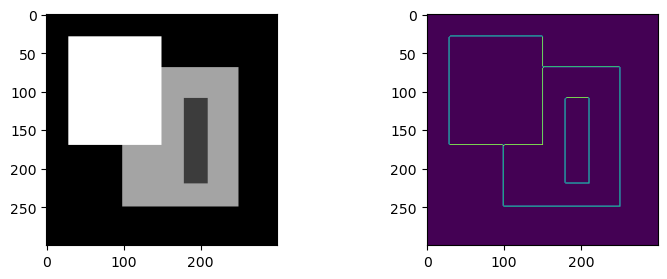

In [249]:
edges1 = cv2.Canny(im1,100,200)

fig, ax = plt.subplots(1,2, figsize=(9,3))
ax[0].imshow(im1)
ax[1].imshow(edges1)
plt.show()

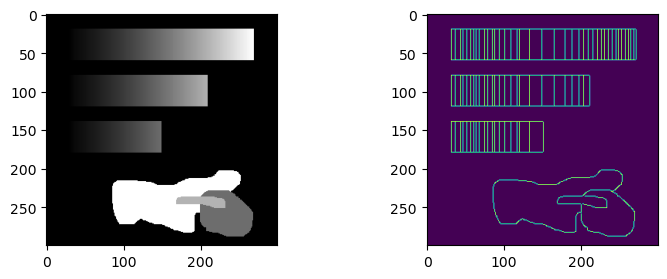

In [252]:
edges2 = cv2.Canny(im2,3,200)

fig, ax = plt.subplots(1,2, figsize=(9,3))
ax[0].imshow(im2)
ax[1].imshow(edges2)
plt.show()